In [35]:
import pandas as pd    #ok
import numpy as np    #ok
import matplotlib.pyplot as plt    #ok
import re    #전처리 축약표현 사용
from konlpy.tag import Okt        #트위터분석기(한글분석-데이터수집처리 ex.0109)
from tensorflow.keras.preprocessing.text import Tokenizer    #???integer Encoding     머신러닝-3
from tensorflow.keras.preprocessing.sequence import pad_sequences  #패딩하기
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# %matplotlib inline
%load_ext autotime

time: 0 ns (started: 2021-06-08 13:13:37 +09:00)


In [21]:
f=open('../data/koreanStopwords.txt', 'r', encoding='UTF8') #불용어 파일 가져오기
kkk=f.readlines()
f.close()

list3=[]
for x in kkk:
    list3.append(x[:-1].split('\t'))
list4=[]
for j in list3:
    list4.append(j[0])

list4=[x for x in list4 if len(x)!=1]

In [22]:
def remove_stopwords(text): #불용어 처리 함수
    list5=[]
    for t in text:
        okt =Okt()
        tokens = okt.morphs(t, stem=True)
        tokens = [ w for w in tokens if not w in list4]
        tokens = [e for e in tokens if len(e)!=1]
        list5.append(tokens)
    return list5

In [23]:
f=open('../data/naver_movie_reviews_test.txt','r',encoding='UTF8')    # 테스트 파일불러오기
test=f.readlines()
f.close()

list1=[]   #불러온Test파일 리스트화
for x in test:
#x=re.sub('[-!?()>~.]',' ',x) #특수문자>스페이스 
#x=re.sub('ㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ',' ',x) #단모음제거
    list1.append(x[:-1].split('\t'))


df=pd.DataFrame(list1[1:]) #데이터프레임으로변환
df.columns=list1[0] #칼럼지정
df.drop_duplicates('id') #id 중복제거  >중복 x

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [24]:
f=open('../data/naver_movie_reviews_train.txt','r',encoding='UTF8')  #트레인 파일불러오기
train=f.readlines()
f.close()

list2=[]   #불러온Train파일 리스트화
for x in train:
    list2.append(x[:-1].split('\t'))

df1=pd.DataFrame(list2[1:]) #데이터프레임으로변환
df1.columns=list2[0] #칼럼지정
df1.drop_duplicates('id') #id 중복제거 >중복 x

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [25]:
print(df.loc[df1.document.isnull()],df1.loc[df1.document.isnull()]) # 결측치 제로

Empty DataFrame
Columns: [id, document, label]
Index: [] Empty DataFrame
Columns: [id, document, label]
Index: []


In [26]:
print(df['id'].nunique(),df1['id'].nunique()) #id 중복 제로

50000 150000


In [27]:
print(df['document'].nunique(),df1['document'].nunique())  #document 중복되지되는 항 Test =842, Train= 3817

49158 146183


In [28]:
df.drop_duplicates(subset=['document'], keep='first', inplace=True) #Test중복제거
df1.drop_duplicates(subset=['document'], keep='first', inplace=True) #Train중복제거
print(len(df),len(df1)) #중복제거 확인


49158 146183


In [29]:

#All_data=pd.concat([df,df1]) #Test(49158개) + Train(146183개)
#All_data=All_data.iloc[:,[1,2]]

#All_data #Test(49158개) + Train(146183개)

df['document'] = df['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #test 전처리
df['document'] = df['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
df['document'] = df['document'].str.replace("[0-9]","")

df1['document'] = df1['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #train 전처리
df1['document'] = df1['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
df1['document'] = df1['document'].str.replace("[0-9]","")

df['document'] = df['document'].str.replace('^ +', "") #스페이스제거
df['document'].replace('', np.nan, inplace=True) #결측치확인
df = df.dropna(how = 'any') #결측치제거

df1['document'] = df1['document'].str.replace('^ +', "") #스페이스제거
df1['document'].replace('', np.nan, inplace=True) #결측치확인
df1= df1.dropna(how = 'any') #결측치제거

print(len(df),len(df1))

<ipython-input-29-a295328efb6d>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #test 전처리
<ipython-input-29-a295328efb6d>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
<ipython-input-29-a295328efb6d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace("[0-9]","")
<ipython-input-29-a295328efb6d>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['document'] = df1['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #train 전처리
<ipython-input-29-a295328efb6d>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['document'] = df1['document'].str.replace("[.,;:|\)*~`

48789 145278


<ipython-input-29-a295328efb6d>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['document'] = df1['document'].str.replace('^ +', "") #스페이스제거


In [33]:
"""#### 1.2 토큰화 & 불용어 처리.

1. 자연어 자료를 분절 (토큰화) 처리한다. 모든 품사 또는 명사만을 사용할 수 있다.
2. 한글 불용어 사전을 만들어서 적용한다.
3. 데이터 분량을 줄이는 것도 고려해 본다.
"""

#for i, x in enumerate(list(df.document)): #Test 전처리
#df.document[i]=preprocessing(x)


#for i, x in enumerate(list(df1.document)): #Train 전처리
#df1.document[i]=preprocessing(x)

okt = Okt()
X_Test = []
for sentence in df['document']:
    X_test = okt.morphs(sentence, stem=True) # 토큰화
    X_test = [word for word in X_test if not word in list4] # 불용어 제거
    X_test = [x for x in X_test if len(x)!=1]
    X_Test.append(X_test)



X_Train = []
for sentence in df1['document']:
    X_train = okt.morphs(sentence, stem=True) # 토큰화
    X_train = [word for word in X_train if not word in list4] # 불용어 제거
    X_train = [x for x in X_train if len(x)!=1]
    X_Train.append(X_train)

In [34]:
"""#### 1.3. Integer Encoding: 첫 시도.

1. 정수 인코딩 (integer encoding)을 적용해 본다. TensorFlow의 Tokenizer()를 사용한다.
2. 단어의 개수에 제한을 둘 필요가 있다. 모든 단어를 다 사용하는 것이 좋은 모델링은 아니다.
3. 인덱스 0은 padding의 용도로 사용될 것이기 때문에 +1 해야한다.
4. 인덱스 1은 OOV (out of vocabulary)를 나타내는 용도로 사용될 것이기 때문에 +1 해야 한다.
5. 정수 인코딩 후 혹시 빈 문장이 있으면 제거한다. <= 단어의 개수에 제약을 두었기 때문에 빈 문장이 새롭게 발생할 수도 있다!
"""

tokenizer=Tokenizer(oov_token='<OOV')
tokenizer.fit_on_texts(X_Train)
print(tokenizer.word_index) #단어집합생성  >>빈도수 많은 순서대로   (41578 총개수)

{'<OOV': 1, '영화': 2, '보다': 3, '하다': 4, '없다': 5, '이다': 6, '있다': 7, '좋다': 8, '너무': 9, '정말': 10, '되다': 11, '재밌다': 12, '같다': 13, '진짜': 14, '으로': 15, '아니다': 16, '않다': 17, '에서': 18, '만들다': 19, '나오다': 20, '연기': 21, '평점': 22, '최고': 23, '스토리': 24, '드라마': 25, '감동': 26, '보고': 27, '이렇다': 28, '아깝다': 29, '배우': 30, '감독': 31, '그냥': 32, '재미있다': 33, '재미': 34, '내용': 35, '까지': 36, '주다': 37, '자다': 38, '하고': 39, '지루하다': 40, '재미없다': 41, '쓰레기': 42, '모르다': 43, '가다': 44, '들다': 45, '그렇다': 46, '싶다': 47, '작품': 48, '사랑': 49, '알다': 50, '마지막': 51, '이건': 52, '완전': 53, '오다': 54, 'ㅠㅠ': 55, '많다': 56, '처음': 57, '장면': 58, '액션': 59, '주인공': 60, '이렇게': 61, '안되다': 62, '차다': 63, '나다': 64, '최악': 65, '이야기': 66, 'ㅡㅡ': 67, '넘다': 68, '느낌': 69, '연출': 70, '인데': 71, '명작': 72, '좋아하다': 73, '별로': 74, '역시': 75, '받다': 76, '많이': 77, '남다': 78, '이해': 79, '이영화': 80, '괜찮다': 81, '라고': 82, '느끼다': 83, '버리다': 84, '이나': 85, '부터': 86, '먹다': 87, '아름답다': 88, '해주다': 89, '보기': 90, '이고': 91, '무슨': 92, '에게': 93, '기억': 94, '결말': 95, '아쉽다': 96, '인생': 97, '마음'

In [ ]:
# 도수표 출력.
print(tokenizer.word_counts)

In [36]:
count=0 #단어빈도수가 2개 미만인 단어종류 개수
count2=0 #2개미만인단어가 차지하는 개수
for key, value in tokenizer.word_counts.items():
    if(value<2):
        count=count+1 #개수 카운트
print(count)

18067
time: 16 ms (started: 2021-06-08 13:13:52 +09:00)


In [37]:
count2=41578-count

time: 0 ns (started: 2021-06-08 13:13:53 +09:00)


In [38]:
tokenizer = Tokenizer(count2) #단어수를 제한 해버리면 빈도수낮은 뒷부분이 모두 잘림
tokenizer.fit_on_texts(X_Train)
X_Train = tokenizer.texts_to_sequences(X_Train)
X_Test = tokenizer.texts_to_sequences(X_Test)

time: 1.78 s (started: 2021-06-08 13:13:53 +09:00)


In [39]:
print(X_Train[:5])
print(X_Test[:5])

[[318, 13, 168, 481], [320, 26, 436, 1, 1133, 20, 711, 495, 16], [1982, 1837, 4970, 2, 136], [5749, 65, 6905, 134, 33, 4, 21, 3037], [767, 18145, 8249, 20, 612, 1, 2107, 17, 837, 151, 3, 13153, 18146, 810, 162, 151]]
[[543], [21, 300, 16, 200, 571, 15], [39, 16, 52, 230, 36, 89, 183], [15, 1785, 36, 19, 10889, 583, 3], [129, 2419, 10, 22, 129, 1]]
time: 0 ns (started: 2021-06-08 13:13:56 +09:00)


In [40]:
# X_Train=[[318, 13, 168, 481]
#         [320, 26, 436, 1, 1133, 20, 711, 495, 16]
#         [1982, 1837, 4970, 2, 136]...]

Y_Test = list(df['label'])
Y_Test=[int(i) for i in Y_Test]
Y_Test=np.array(Y_Test)

time: 15 ms (started: 2021-06-08 13:13:57 +09:00)


In [41]:
Y_Train = np.array(df1['label'])
Y_Train=[int(i) for i in Y_Train]
Y_Train=np.array(Y_Train)

time: 32 ms (started: 2021-06-08 13:13:59 +09:00)


In [42]:
Y_Test

array([1, 0, 0, ..., 0, 0, 0])

time: 16 ms (started: 2021-06-08 13:14:01 +09:00)


In [43]:
Y_Train

array([0, 1, 0, ..., 0, 1, 0])

time: 0 ns (started: 2021-06-08 13:14:02 +09:00)


In [44]:
len(X_Train)
len(Y_Train)

145278

time: 0 ns (started: 2021-06-08 13:14:02 +09:00)


In [45]:
drop_train=[ x for x,y in enumerate(X_Train) if len(y)<1]  #빈샘플들 제거

X_Train = np.delete(X_Train, drop_train, axis=0)
Y_Train = np.delete(Y_Train, drop_train, axis=0)
print(len(X_Train))
print(len(Y_Train))

144384
144384
time: 110 ms (started: 2021-06-08 13:14:03 +09:00)


C:\Users\PC\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


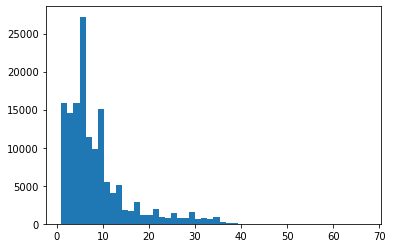

time: 594 ms (started: 2021-06-08 13:14:03 +09:00)


In [46]:
plt.hist([len(s) for s in X_Train], bins=50)
plt.show()

In [48]:

"""#### 1.4. Padding 적용.
# b1. 문장 길이의 분포를 탐색해 본다. HINT: 히스토그램 활용.
2. Padding을 적용해 본다. HINT: pad_sequences() 함수 사용.
"""
X_Train = pad_sequences(X_Train, maxlen = 30)
X_Test = pad_sequences(X_Test, maxlen = 30)

len(X_Train[0])
len(X_Train)

144384

time: 438 ms (started: 2021-06-08 13:14:54 +09:00)


In [49]:
X_Train

array([[   0,    0,    0, ...,   13,  168,  481],
       [   0,    0,    0, ...,  711,  495,   16],
       [   0,    0,    0, ..., 4970,    2,  136],
       ...,
       [   0,    0,    0, ..., 9522, 9460,  785],
       [   0,    0,    0, ..., 2430,  933, 7032],
       [   0,    0,    0, ...,   34, 1048,    1]])

time: 0 ns (started: 2021-06-08 13:14:55 +09:00)


In [50]:
X_Test

array([[   0,    0,    0, ...,    0,    0,  543],
       [   0,    0,    0, ...,  200,  571,   15],
       [   0,    0,    0, ...,   36,   89,  183],
       ...,
       [   0,    0,    0, ...,  193, 2796,   18],
       [   0,    0,    0, ..., 2334,   17, 6955],
       [   0,    0,    0, ...,    0,  683,  931]])

time: 0 ns (started: 2021-06-08 13:14:56 +09:00)


In [51]:
######################여기까지 완성   57번째 실행

"""#### 2. LSTM 사용한 모델링과 학습.

B1. LSTM 모델을 정의한다. 
2. Hyperparameter를 정의한다.
3. Callback 정의.
4. Optimizer 객체 생성과 모델 컴파일.
5. 학습 실행.
6. 예측 정확도 계산 (학습 데이터 사용).
"""

n_epochs=15
batch_size=128
n_words = count2 + 2
DIM = 100                                                            # Embedding 차원수.
n_hidden = 128

time: 0 ns (started: 2021-06-08 13:14:57 +09:00)


In [52]:
my_model = Sequential()
my_model.add(Embedding(n_words,DIM))
my_model.add(LSTM(units=n_hidden, return_sequences=False))            # Sequence To Vector.
my_model.add(Dense(units=1, activation='sigmoid'))                     # 긍/부정 감성.

time: 406 ms (started: 2021-06-08 13:14:58 +09:00)


In [ ]:
my_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = my_model.fit(X_Train, Y_Train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

In [56]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2351300   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,468,677
Trainable params: 2,468,677
Non-trainable params: 0
_________________________________________________________________
time: 0 ns (started: 2021-06-08 13:26:35 +09:00)


In [54]:
my_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = my_model.fit(X_Train, Y_Train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1926/1926 [==============================] - 55s 28ms/step - loss: 0.4063 - acc: 0.8112 - val_loss: 0.3764 - val_acc: 0.8325

Epoch 00001: val_acc improved from -inf to 0.83253, saving model to best_model.h5
Epoch 2/15
1926/1926 [==============================] - 52s 27ms/step - loss: 0.3169 - acc: 0.8621 - val_loss: 0.3661 - val_acc: 0.8391

Epoch 00002: val_acc improved from 0.83253 to 0.83908, saving model to best_model.h5
Epoch 3/15
1926/1926 [==============================] - 53s 28ms/step - loss: 0.2636 - acc: 0.8882 - val_loss: 0.3957 - val_acc: 0.8362

Epoch 00003: val_acc did not improve from 0.83908
Epoch 4/15
1926/1926 [==============================] - 53s 28ms/step - loss: 0.2203 - acc: 0.9086 - val_loss: 0.4275 - val_acc: 0.8308

Epoch 00004: val_acc did not improve from 0.83908
Epoch 5/15
1926/1926 [==============================] - 54s 28ms/step - loss: 0.1826 - acc: 0.9252 - val_loss: 0.4850 - val_acc: 0.8253

Epoch 00005: val_acc did not improve from 0.8390

In [55]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_Test, Y_Test)[1]))

1525/1525 [==============================] - 6s 4ms/step - loss: 0.3713 - acc: 0.8354

 테스트 정확도: 0.8354
time: 6.69 s (started: 2021-06-08 13:20:22 +09:00)


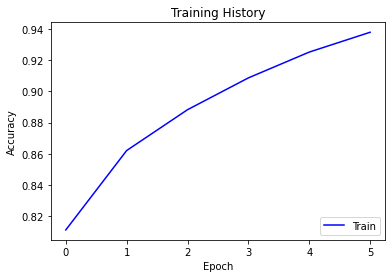

time: 141 ms (started: 2021-06-08 13:28:56 +09:00)


In [61]:
# 학습 history 출력. 
plt.plot(history.history['acc'], c="b")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [62]:
my_model.evaluate(X_Test, Y_Test)

1525/1525 [==============================] - 6s 4ms/step - loss: 0.5664 - acc: 0.8182


[0.5664234757423401, 0.8181557059288025]

time: 5.89 s (started: 2021-06-08 13:39:14 +09:00)


In [63]:
prediction = my_model.predict(X_Test)
prediction

array([[9.5609522e-01],
       [6.0752821e-01],
       [4.0891629e-01],
       ...,
       [7.6958823e-01],
       [2.1624565e-04],
       [6.8614441e-01]], dtype=float32)

time: 5.72 s (started: 2021-06-08 13:39:21 +09:00)


In [66]:
"""#### 3. 감성 예측.

- 다음과 같이 헬퍼함수 sentiment_prediuct를 정의하여 감성 예측을 실시해 본다!
"""

def sentiment_predict(text):
    text = text.replace("[^ㅏ-ㅣ가-힣 ]","")    #train 전처리
    text = text.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
    text = text.replace("[0-9]","")
    text = text.replace('^ +', "") #스페이스제거
    
    
    text = okt.morphs(text, stem=True) #형태소분리
    text = [ w for w in text if not w in list4] #불용어제거
    
    IntegerE = tokenizer.texts_to_sequences([text]) #정수인코딩
    pading= pad_sequences(IntegerE, maxlen = 20) #패딩
    score = float(loaded_model.predict(pading)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

time: 0 ns (started: 2021-06-08 13:39:54 +09:00)


In [75]:
sentiment_predict('꿀잼 ㅎㅎㅎ  강추! ㅋㅋㅋ')

99.31% 확률로 긍정 리뷰입니다.

time: 31 ms (started: 2021-06-08 13:46:33 +09:00)


In [80]:
sentiment_predict('이런 망작이~~')

99.79% 확률로 부정 리뷰입니다.

time: 32 ms (started: 2021-06-08 13:47:03 +09:00)


In [77]:
sentiment_predict('들인 돈이 아깝다')

99.03% 확률로 부정 리뷰입니다.

None
time: 31 ms (started: 2021-06-08 13:46:42 +09:00)


In [78]:
sentiment_predict('이번 주말에 연인과 함께 시청 추천해요!')

96.16% 확률로 긍정 리뷰입니다.

None
time: 31 ms (started: 2021-06-08 13:46:50 +09:00)


In [79]:
sentiment_predict('낮은 기대치 만큼 역시나 볼것 없는 영화였다.')

50.63% 확률로 긍정 리뷰입니다.

None
time: 46 ms (started: 2021-06-08 13:46:52 +09:00)
